# 분류 실습 : 캐글 신용카드 사기 검출

## **데이터 일차 가공 및 모델 학습 / 예측 / 평가**

**'creditcard.csv' 파일 데이터 로드**

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [3]:
card_df.shape

(284807, 31)

In [4]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

**creditcard 피처 정보**
- Time : 

## **전처리 함수 1️⃣get_preprocessed**

In [6]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사 한 뒤 Time칼럼만 삭제하고 복사된 DataFrame반환
def get_preprocessed_df(df = None):
    df_copy = df.copy()
    df_copy.drop('Time', axis = 1, inplace = True)
    return df_copy

**학습과 테스트 데이터 세트를 반환하는 함수 생성**
- 사전 데이터 처리가 끝난 뒤 해당 함수 호출

`get_train_test_dataset(df = None)`

In [17]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수
def get_train_test_dataset(df = None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame반환
    df_copy = get_preprocessed_df(df)
    
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    
    # train_test_split()으로 학습과 테스트 데이터 분할
    # stratify = y_target으로 Stratified기반 분할
    # stratify : 타켓 값의 분포도에 맞춰, 학습과 테스트 맞춰서 분할 (레이)
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.3, random_state = 0, stratify = y_target)
    
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [18]:
y_train.value_counts()

0    199020
1       344
Name: Class, dtype: int64

정상 : 199020개 (0)

비정상(사기) : 344개 (1)

In [11]:
y_train.shape

(199364,)

**학습/테스트 데이터 레이블 비율**

In [13]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts() / y_train.shape[0] * 100)
print('\n테스트 데이터 레이블 값 비율')
print(y_test.value_counts() / y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64

테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


관심있는 데이터(1)의 건수는 매우 적다

**LogisticRegression 알고리즘 적용하여 학습 / 예측 / 평가 수행**

In [28]:
# 예측 평가 수행 함수 (앞에서 복사한 것)
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

# 수정된 get_clf_eval() 함수
def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [21]:
# 먼저 LogisticRegression부터 학습/예측/평가 수행
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)

In [22]:
# 3장에서 사용한 get_clf_eval() 함수를 이용하여 평가 수행. 
get_clf_eval(y_test, lr_pred)

오차 행렬
[[85281    14]
 [   55    93]]
정확도: 0.9992, 정밀도: 0.8692, 재현율: 0.6284,    F1: 0.7294, AUC:0.8141


<결과> 정확도가 약 99.9%

### **모델을 학습 / 예측 / 평가를 위한 함수 생성**
: 앞으로 피처 엔지니어링을 수행할 때마다 사용

`get_model_train_eval(model, ftr_train = None, ftr_test = None, tgt_train = None, tgt_test = None)`

In [27]:
# 인자로 사이킷런의 Estimator객체와, 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train = None, ftr_test = None, tgt_train = None, tgt_test = None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test, pred, pred_proba)

### **LightGBM 학습 / 예측 / 평가**
- boost_from_average가 True일 경우 레이블 값이 극도로 불균형 분포를 이루는 경우 재현율 및 ROC-AUC성능이 매우 저하됨
- LightGBM 2.1.0 

In [29]:
from lightgbm import LGBMClassifier

# boost_from_average : 에러까지는 아닌데 T
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)

get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.8783


### **데이터 분포도 변환 후 모델 학습/예측/평가**
**중요 feature의 분포도 확인**

<AxesSubplot:xlabel='Amount', ylabel='Density'>

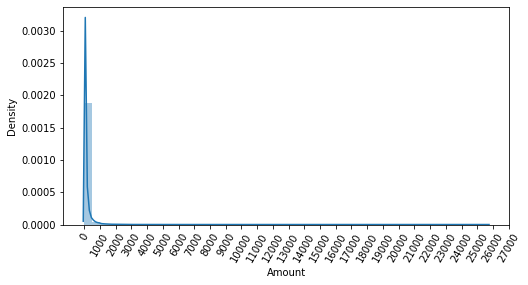

In [31]:
# 중요 속성으로 Amount 선정해서 분포도 확인
import seaborn as sns

plt.figure(figsize = (8, 4))
plt.xticks(range(0, 30000, 1000), rotation = 60)
sns.distplot(card_df['Amount'])

## **전처리 함수 2️⃣get_preprocessed_df()수정**
- StandardScaler를 이용하여 Amount 피처 변환 추가

In [33]:
from sklearn.preprocessing import StandardScaler

# Scaled된 값 Amount_Scaled 추가하고, 기존의 Time, Amount 피처 삭제
# 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount 피처값 변환하는 로직으로 수정
def get_preprocessed_df(df = None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    
    # 변환된 Amount를 Amount_Scaled로 피처명 변경 후 DataFrame맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    
    # 기존 Time, Amount피처 삭제
    df_copy.drop(['Time','Amount'], axis = 1, inplace = True)
    return df_copy

**Amount_Scaled로 피처명 변경 후 DataFrame맨 앞 컬럼으로 입력된 것 확인**

In [37]:
card_df2 = get_preprocessed_df(card_df)
card_df2.head()

,Amount_Scaled,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.244964,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.342475,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,1.160686,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,0.140534,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-0.073403,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


**StandardScaler 변환 후 로지스틱 회귀 및 LightGBM 학습 / 예측 / 평가**

In [39]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('로지스틱 회귀 예측 성능')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

print('\nLightGBM 예측 성능')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

로지스틱 회귀 예측 성능
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.8040

LightGBM 예측 성능
오차 행렬
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500,    F1: 0.8409, AUC:0.8750


<AxesSubplot:xlabel='Amount_Scaled', ylabel='Density'>

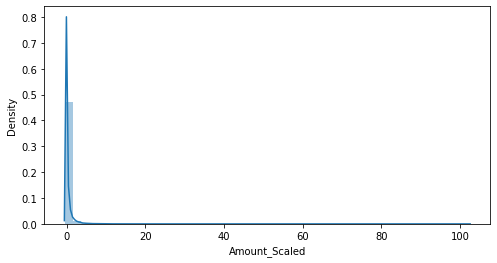

In [41]:
import seaborn as sns

plt.figure(figsize = (8, 4))
#plt.xticks(range(0, 30000, 1000), rotation = 60)
sns.distplot(card_df2['Amount_Scaled'])

정규 분포 형태로 Amount 피처값을 변환한 후 테스트 데이터 세트에 적용한 로지스틱 회귀 및 LightGBM 두 모델 모두 변환 이전과 비교해 성능이 크게 개선되지는 않았음

여전히 치우져진 데이터 ⇒ 성능이 개선되지 않았음

## **전처리 함수 3️⃣get_preprocessed_df()수정**
- 비대칭 분포를 갖는 Amount피처를 로그 변환
- 넘파이의 로그 변환 함수는 np.log()인데, 보통 로그 변환할 때 log() 잘 안쓰고 log1p() 사용
- 1p가 원 플로스로 하나를 더하겠다는 의미

In [42]:
def get_preprocessed_df(df = None):
    df_copy = df.copy()
    
    # 넘파이의 log1p()를 이용하여 Amount를 로그 변환
    amount_n = np.log1p(df_copy['Amount'])
    
    # Amount_Scaled칼럼 추가하고 'Time', 'Amount'삭제
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis = 1, inplace = True)
    return df_copy

**log1p 와 expm1 설명**

In [ ]:
# log1p 와 expm1 설명
import numpy as np

# log(-1000)

**LogisticRegression 알고리즘 적용하여 학습 / 예측 / 평가 수행**

In [43]:
# 학습 / 테스트 데이터 분리하고
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('로지스틱 회귀 예측 성능')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

print('\nLightGBM 예측 성능')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

로지스틱 회귀 예측 성능
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC:0.8006

LightGBM 예측 성능
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.8817


<AxesSubplot:xlabel='Amount_Scaled', ylabel='Density'>

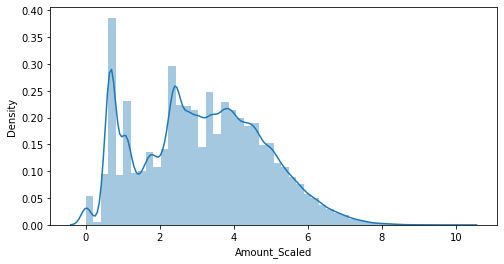

In [45]:
import seaborn as sns

card_df2 = get_preprocessed_df(card_df)
plt.figure(figsize = (8, 4))
sns.distplot(card_df2['Amount_Scaled'])

Amount 피처 로그변환하지 않은 데이터로 학습한 경우보다 약간씩 성능이 개선됨

### **이상치 데이터 제거 후 모델 학습 / 예측 / 평가**
#### **각 피처들의 상관 관계 시각화 : 히트맵(heapmap)**
- 결정 레이블인 class값과 가장 상관도가 높은 피처 추출
- 추출한 다음 이 중에 상관도가 높은 피처들에 대해서 아웃 라이어 찾음
- 그 다음에 거기에 대한 아웃 라이어가 높은 피처들을 가지고 있는 레코드 삭제

<AxesSubplot:>

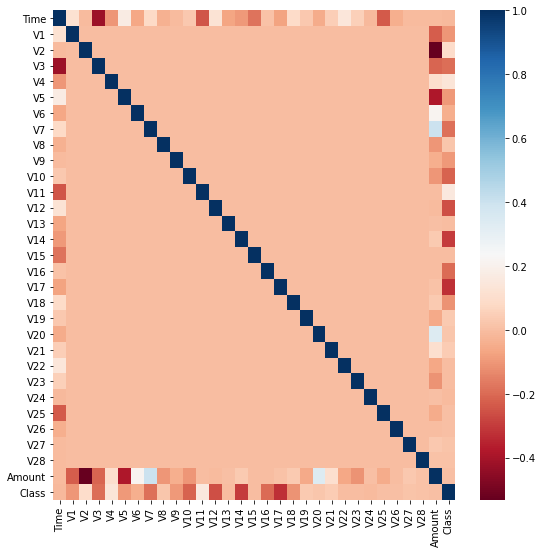

In [46]:
import seaborn as sns

plt.figure(figsize = (9, 9))
corr = card_df.corr()  # 각 칼럼들의 상관도 값 반환
sns.heatmap(corr, cmap = 'RdBu')  

히트맵에서 cmap을 'RdBu'로 설정
- 레드 : 음의 상관관계 
    - 음의 상관관계가 높을수록 색깔이 진한 빨강에 가깝게 표현
- 블루 : 양의 상관관계
    - 양의 상관관계가 높을수록 색깔이 진한 파란색에 가깝게 표현
    
레이블 Class와 상관관계가 가장 높은 피처는 V14와 V17
- 음의 상관관계 (제일 진한 빨강)

위 히트맵 레이블 Class와 상관관계가 가장 높은 피처인 V14에 대해서만 이상치를 찾아서 제거
- IQR을 이용해 이상치를 검출하는 함수 생성한 뒤, 이를 이용해 검출된 이상치를 삭제

### **이상치 필터링을 위한 함수 작성 : get_outlier()**
- 수치형 데이터 사용
- DataFrame에서 outlier에 해당하는 데이터를 필터링
- outlier 레코드의 index를 반환함


함수 내에서 넘파이의 percentile()을 이용해 1/4분위와 3/4분위를 구하고, 이에 기반해 IQR계산

계산된 IQR에 1.5를 곱해서 최댓값과 최솟값 지점을 구한 뒤, 최댓값보다 크거나 최솟값보다 작은 값을 이상치로 설정하고 해당 이상치가 있는 DataFrame index반환

In [52]:
# 아웃라이어(이상치)를 찾기 위함 함수 새로 생성
import numpy as np

# weight는 boxplot에서 이상치 계산 시 1.5 * IQR(몸통)을 더하고, 뺀 값들이 이상치
# 전체 데이터에서 찾지 않고 사기 데이터에서 찾음
# 사기 데이터 : Class = 1
def get_outlier(df = None, column = None, weight = 1.5):
    # fraud에 해당하는 column데이터만 추출, 1/4분위와 3/4분위 지점을 np.percentile로 구함
    fraud = df[df['Class'] == 1][column]  # column값으로 V14 들어올 것임
    quantile_25 = np.percentile(fraud.values, 25)  # 1분위 수
    quantile_75 = np.percentile(fraud.values, 75)  # 3분위 수
    
    # IQR을 구하고, IQR에 1.5을 곱하여 최대값과 최소값 지점 구함
    iqr = quantile_75 - quantile_25
    
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    # 데이터 프레임 인덱스 찾음
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    
    return outlier_index

**피처 V14의 분포**
- 사분위수

In [54]:
# 1분위수
np.percentile(card_df['V14'], 25) 

-0.4255740124549935

In [56]:
# 3분위수 : 상위 75%
np.percentile(card_df['V14'], 75)

0.493149849218149

In [57]:
# np.percentile(card_df['V14'].value, 100)
np.max(card_df['V14'])

10.5267660517847

**get_outlier()함수를 이용해 V14 칼럼에서 이상치 데이터를 찾기**

In [53]:
outlier_index = get_outlier(df = card_df, column = 'V14', weight = 1.5)
print('이상치 데이터 인덱스 : ', outlier_index)

이상치 데이터 인덱스 :  Int64Index([8296, 8615, 9035, 9252], dtype='int64')


4개의 인덱스 [8296, 8615, 9035, 9252]
: 이 인덱스에 해당되는 행은 삭제할 것

In [58]:
card_df['V14']

0        -0.311169
1        -0.143772
2        -0.165946
3        -0.287924
4        -1.119670
            ...   
284802    4.626942
284803   -0.675143
284804   -0.510602
284805    0.449624
284806   -0.084316
Name: V14, Length: 284807, dtype: float64

In [59]:
card_df['V14'][100]

0.796994975493623

<AxesSubplot:xlabel='V14', ylabel='Density'>

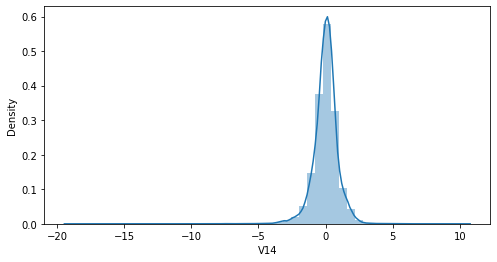

In [60]:
import seaborn as sns

plt.figure(figsize = (8, 4))
sns.distplot(card_df2['V14'])

0을 중심으로 +-5 범위내에 대부분 데이터 존재  

## **전처리 함수 4️⃣get_processed_df()**
- Amount 피처 로그 변환
- V14 피처의 이상치 데이터 삭제

In [61]:
# 이상치 데이터 삭제하는 로직 추가

# get_processed_df()를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경
def get_preprocessed_df(df = None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis = 1, inplace = True)
    
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df = df_copy, column = 'V14', weight = 1.5)
    df_copy.drop(outlier_index, axis = 0, inplace = True)  # axis = 0 : 행삭제
    return df_copy

### **로그변환, 이상치 제거 후 모델들을 재 학습/예측/평가**

In [62]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('로지스틱 회귀 예측 성능')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

print('\nLightGBM 예측 성능')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

로지스틱 회귀 예측 성능
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,    F1: 0.7597, AUC:0.8355

LightGBM 예측 성능
오차 행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288,    F1: 0.8897, AUC:0.9144


## **SMOTE 오버 샘플링 적용 후 모델 학습 / 예측 / 평가**

In [ ]:
from imblearn.over_sampling import SMOTE

# SMOTE 객체 생성
smote = SMOTE(random_state = 0)

# train 데이터 세트로 들어오는 값들에 대해서 오버샘플링 시작
# 타켓값의 분포에 맞춰 피처값 생성

# 교재 smote.fit_sample()의 경우 : 'SMOTE' object has no arribute 'fit sample' d오류 메시지 발생
# smot.fit_resample()로 변경

X_train_over, y_train_over - smote.fit_resample(X_train, y_train)

# 전체 데이터 : 284, 807
# 테스트 : 30%, 학습 : 70%

print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : ', X_train.shape, y_train.shape)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포 : \n', pd.Series(y_train_over).value_counts())

In [ ]:
# 원래 이랬음
y_train.value_counts()
# 전체 0.1% 만 1 값이었음

### **오버 샘플링 된 데이터로 로지스틱 회귀로 학습 / 예측 / 평가**

**증식된 데이터에 기반해서 다시 모델 학습 / 예측 / 평가**

In [ ]:
lr_clf = LogisticRegression()

# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

**Precision-Recall 곡선 시각화**

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

In [ ]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

재현율은 좋은데 정밀도 너무 낮음
- 차이가 너무 극명하게 난다
- 성능은 좋아졌지만 좋은 모델은 아님

**오버샘플링 된 데이터로 LightGBM 모델 적용**

In [ ]:
lgmb_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)

# 샘플링된 데이터 세트 사용
get_model_train_eval(lgbm_clf, ftr_train = X_train_over, ftr_test = X_test, tgt_train = y_train_over , tgt_test = y_test)

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                  tgt_train=y_train_over, tgt_test=y_test)

In [ ]:
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

In [ ]:
적절한 부분 
- 기준은 0.5